# Electrophoretic motion of particles exposed to AC fields and pressure-driven flow

We perform bright field optical microscope simulations of the electrophoretic motion of small Brownian particles exposed to an AC electric field inside a capillary.

First, we compute single particle images at different heights inside the channel as explained in *mie_particle_microscopy.ipynb*.

Next, we define how particle moves. We determine initial particle coordinates and thn iterate over time to construct particle trajectories. In the current implementation, we simulate Brownian diffusion in the xy plane only, so the particles do not move out of the plane. This is because the out of-plane movement does not play a considerable role in the Fourier analysis, so we simplify the computation and analysis by fixing particle's position within the plane. In addition, this restriction significantly simplifies simulations, as each particle image LUT does not change with time, and can be computed only once at the beginning of the experiment. 

The electrophoretic motion is determined based on the particle's position with respect to the distance from the capillary wall, as well as the amplitude and frequency of the applied external AC electric field. 

Pressure driven flow is simulated by assuming a parabolic flow profile over the capillary thickness. Based on the position of the particle inside the capilarry, we asign a fixed velocity to each particle.

We record a video sampled with regular or irregular sampling schemes.


Library settings
------------------------------------------------------------------------
Using MLX:           False
Using Numba:         True
FFT library:         'scipy'
Precission:          'single'
Using fastmath:      True
Numba target:        'cpu'
Num threads (FFT):   4
Num threads (Numba): 4
numpy 2.2.6
scipy 1.16.2
numba 0.61.2
miepython 3.0.2
Camera settings
------------------------------------------------------------------------
Sensor shape:               (512, 512)
Pixel size:                 6.9 um
Relative exposure level:    50.0 %
Sensor full well capacity:  16384 e-
Shot noise type:            'normal'
ADC resolution:             10bit
Expected mean 0.5
Measured mean 0.49997088
Expected STD 0.005524271728019903
Measured STD 0.0055265105


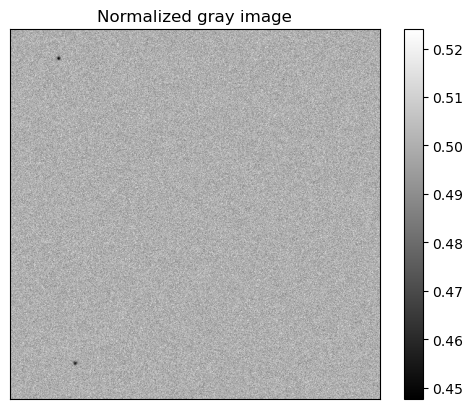

Microscope settings
------------------------------------------------------------------------
Magnification factor:         60.0x
Objective numerical aperture: 0.9
Condenser numerical aperture: 0.15
Source nominal wavelength:    550.0 nm
Source bandwidth:             28.0 nm


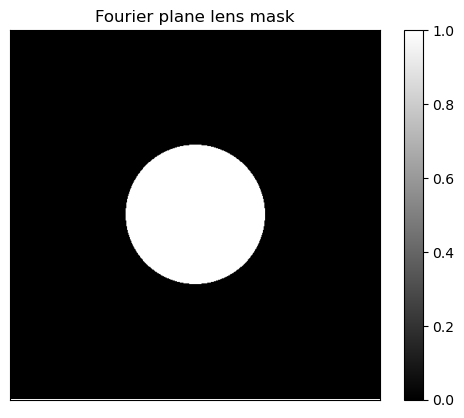

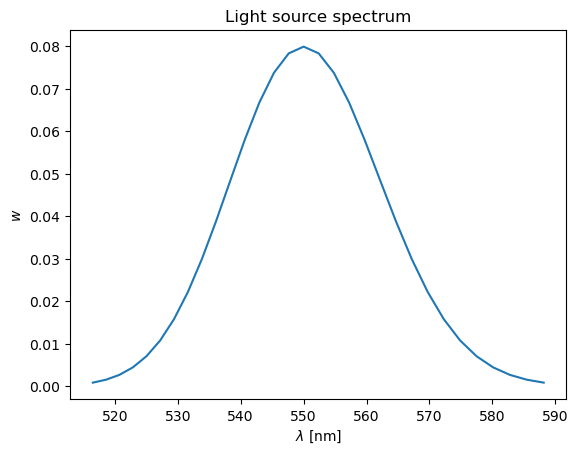

Building particle FFT LUTs
|==================================================| 100.0 % Done in  1.2 m


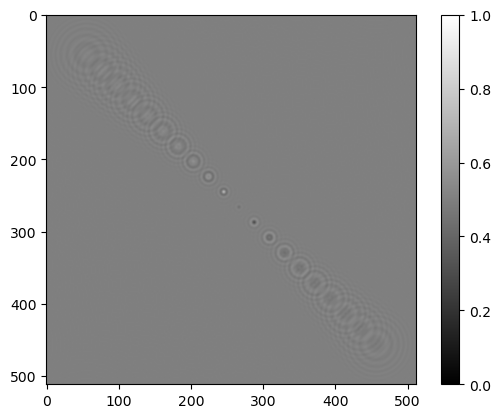

Applying koehler


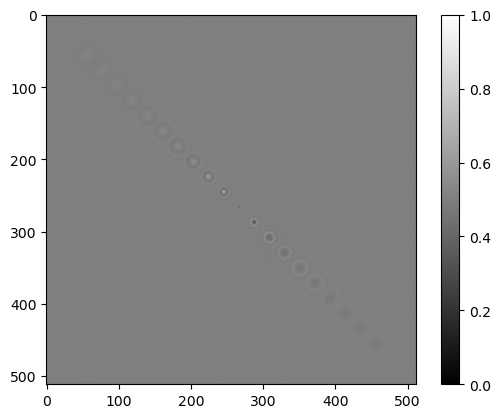

Building LUTs
Computing image


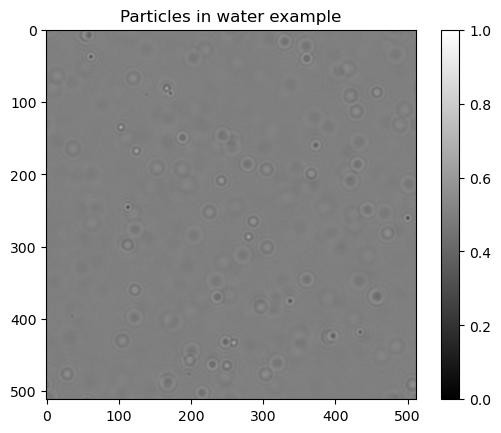

319 ms ± 32.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
run mie_particle_microscopy.ipynb

### Sample preparation 

Here we set sample properties. These settings define how we simulate brownian motion and electrophoretic motion.

In [2]:
## Experiment settings
#----------------------
assert_lut_ok() #make sure we have lookup tables

SAVE_FIGS = True

#: relative size distribution parameter
SIZE_DISTRIBUTION = 0.01 # 

#: mean particle mobility
MOBILITY = -5e-8 #m2/Vs

#: relative mobility distribution,  sigma = MOBILITY * MOBILITY_DISTRIBUTION
MOBILITY_DISTRIBUTION = 0.01

#: mean particle flow in the center of the capillary 
FLOW = (0e-7,0e-6) # m/s
FLOW = (0e-7,-20e-6) # m/s

#: mean flow sigma 
FLOW_SIGMA = (0e-7,0e-7) # m/s

#: water viscosity
VISCOSITY = 10**(-3) #Pas

#: water temperature
TEMPERATURE = 300 #K

#: water ppermitivity
PERMITTIVITY = 80

#: water density
DENSITY = 1000

# wall zeta potential
WALL_ZETA = 80e-3

#: wall mobility parameter
WALL_MOBILITY = PERMITTIVITY*8.85e-12 * WALL_ZETA / VISCOSITY

#: whether to apply electroosmosis (apply channel wall effects)
APPLY_WALL_MOBILITY = True

#: effective channel length 
CHANNEL_LENGTH = 0.0156 

_EXPERIMENT_OK = False


def print_sample_settings():
    print("Sample settings")
    print_line("-")
    print(f"Number of particles:        {NUM_PARTICLES}")
    print(f"Particle diameter (mean):   {DIAMETER*1e9:.1f} nm")
    print(f"Particle size distribution: {SIZE_DISTRIBUTION*100} %")
    print(f"Particle mobility (mean):   {MOBILITY} m2/Vs")
    print(f"Mobility ditribution:       {MOBILITY_DISTRIBUTION*100} %")
    print(f"Constant flow (mean):       ({FLOW[0]*1e6:.2f}, {FLOW[0]*1e6:.2f}) um/s")
    print(f"Constant flow (sigma):      ({FLOW_SIGMA[0]*1e6:.2f}, {FLOW_SIGMA[0]*1e6:.2f}) um/s")
    print(f"Fluid viscosity:            {VISCOSITY*1000} mPas")
    print(f"Temperature:                {TEMPERATURE} K")
    print_line("=")

print_sample_settings()
    

Sample settings
------------------------------------------------------------------------
Number of particles:        4000
Particle diameter (mean):   300.0 nm
Particle size distribution: 1.0 %
Particle mobility (mean):   -5e-08 m2/Vs
Mobility ditribution:       1.0 %
Constant flow (mean):       (0.00, 0.00) um/s
Constant flow (sigma):      (0.00, 0.00) um/s
Fluid viscosity:            1.0 mPas
Temperature:                300 K


### Experimental conditions

Here we set AC voltage, triggering scheme and duration time 

In [3]:
#: Whether to use irregular sampling for video 
USE_RANDOM_SAMPLING = True #If set to false, regular video sampling is assumed

#: How many frames to compute
COUNT = 2**16

#: Effective camera frame rate
FPS = 1000

#: AC voltage amplitude
VOLTAGE = 75 #V
#VOLTAGE = 0 #V

#:Electric field amplitude
ELECTRIC_FIELD = (0,VOLTAGE/CHANNEL_LENGTH) #V/m

#: random sampling interval; set to 1 for full data sampling scheme
RANDOM_SAMPLING_INTERVAL = 4 # Should be a power of 2

#: analysis sampling interval, should be the same as PERIOD or a power of 2 higher
REGULAR_SAMPLING_INTERVAL = RANDOM_SAMPLING_INTERVAL*2 + RANDOM_SAMPLING_INTERVAL//2 # Should be a power of 2

#: electric field period in time step units... Frequency should be a multiple of REGULAR_SAMPLING_INTERVAL
PERIOD = REGULAR_SAMPLING_INTERVAL

#: electric field frequency. 
FREQUENCY = FPS / PERIOD #Hz

#: calculated time step in seconds
TSTEP = 1/FPS

assert is_power_of_two(COUNT)

_EXPERIMENT_OK = False

Experiment settings
------------------------------------------------------------------------
AC voltage:                 75 V
AC frequency:               100.0 Hz
AC period:                  10 x dt
Regular sampling interval:  10 x dt
Random sampling interval:   4 x dt
Electric field vector:      (0.0, 4807.7) V/m


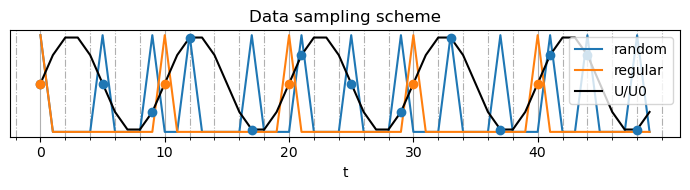

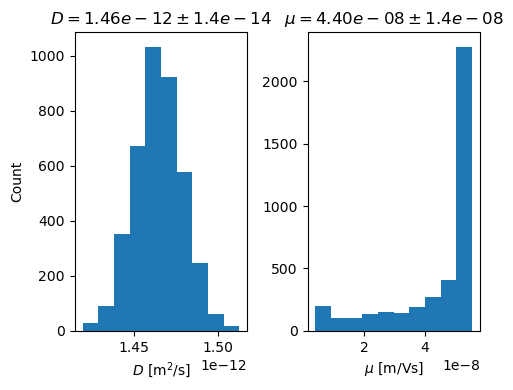

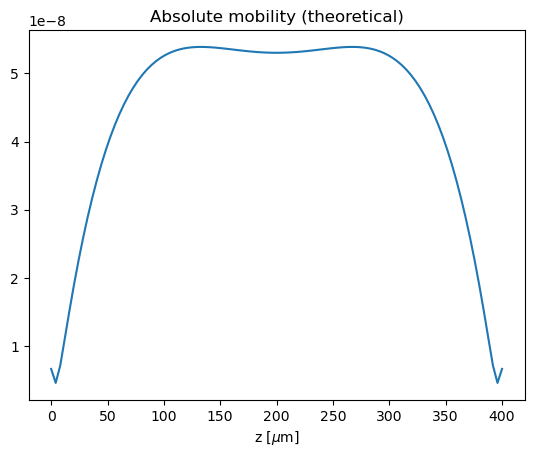

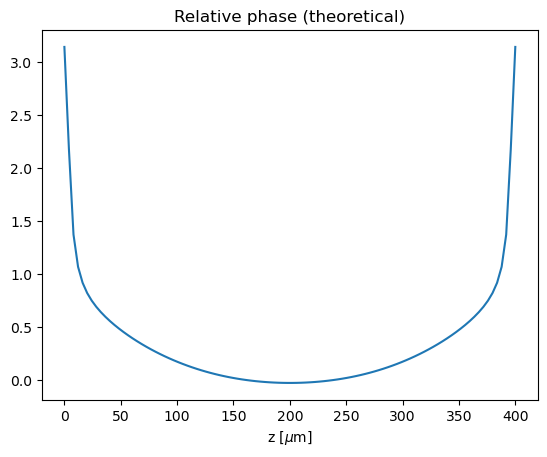

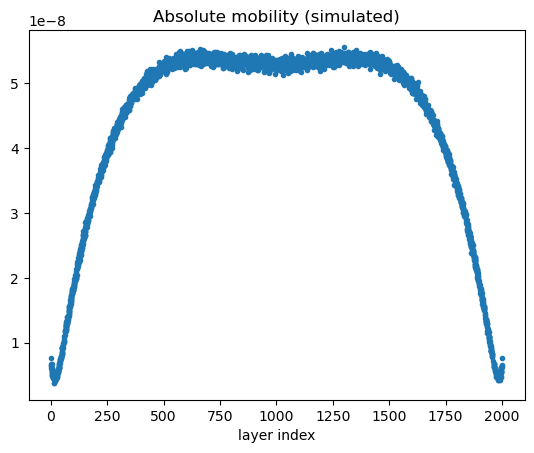

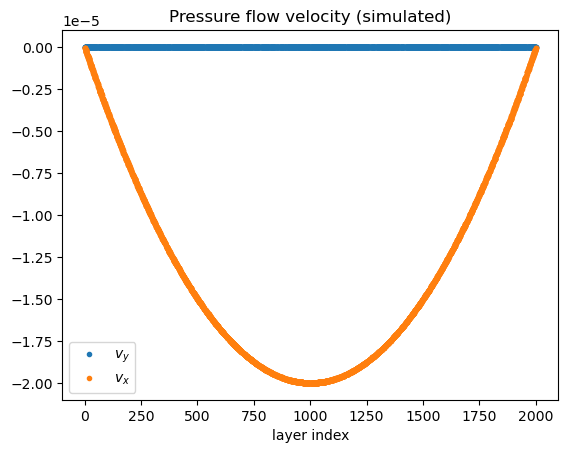

In [4]:
np.random.seed(0)

def complex_mobility(z,mu, h = CHANNEL_THICKNESS, eta = VISCOSITY, rho = DENSITY, freq = FREQUENCY, muw = WALL_MOBILITY):
    omega = 2*np.pi * freq
    delta = np.sqrt(2*eta/rho/omega)
    #l = np.sqrt(1j*omega*rho/eta)
    l = (1+1j)/delta
    return mu + muw * np.cosh(l*(z-h/2))/np.cosh(l*h/2)

#Boltzmann contant times T
KbT = 1.380649e-23 * TEMPERATURE

#Mean diffusion constant
D = KbT/(3 * np.pi * VISCOSITY * DIAMETER)

#assert is_power_of_two(PERIOD)
#assert is_power_of_two(REGULAR_SAMPLING_INTERVAL)
assert is_power_of_two(RANDOM_SAMPLING_INTERVAL)
assert REGULAR_SAMPLING_INTERVAL >= PERIOD

def diffusion_constants():
    """Returns randomized diffusion constants"""
    return np.random.normal(loc = D, scale = D*SIZE_DISTRIBUTION, size = NUM_PARTICLES)

def mobilities():
    """Returns randomized mobility constants"""   
    return np.random.normal(loc = MOBILITY, scale = np.abs(MOBILITY*MOBILITY_DISTRIBUTION), size = NUM_PARTICLES)

def velocities(z,h = CHANNEL_THICKNESS):
    """Returns randomized particle flow velocities"""
    loc = np.zeros((NUM_PARTICLES,2))
    fact = (1- (2*z/h-1)**2)
    loc[...,:] = FLOW * fact[:,None]
    #loc = np.asarray(FLOW_MEAN)[None,:]
    scale = np.asarray(FLOW_SIGMA)
    return np.random.normal(loc = loc, scale = scale)

def _dxB(d, dt,xstep, tstep):
    """Returns Brownian motion dx vector"""
    scale = np.sqrt((2*dt*tstep)*d) / xstep
    return np.random.normal(loc = 0, scale = scale)

#numba speeds up random generation slightly because it can run in parallel 
#if USENUMBA:
#    _dxB = nb.vectorize([nb.float64(nb.float64,nb.int_,nb.float64,nb.float64)],
#            target = NBTARGET, fastmath = NBFASTMATH)(_dxB)
    
def dxB(d,dt):
    """Returns Brownian motion dx vector"""
    d = np.asarray(d)
    xstep = np.asarray(XSTEP)
    return _dxB(d[...,None],dt, xstep, TSTEP)

def _dxF(v,dt,xstep, tstep):
    return v * dt*tstep / xstep

def dxF(v,dt):
    """Returns constant flow dx vector"""
    return _dxF(np.asarray(v), dt,np.asarray(XSTEP), TSTEP)

def _dxE(m,t,ampl,freq, xstep,tstep):
    """Returns Electric field dx vector"""
    omega = 2 * np.pi * freq 
    phi = np.angle(m)
    cosfi = np.cos(omega * tstep * t + phi)
    cosfi0 = np.cos(phi)
    
    step = (-ampl/omega *(cosfi - cosfi0))/xstep
    return np.abs(m) * step
     
def dxE(m,t, out = None):
    """Returns Electric field dx vector"""
    m = np.asarray(m)
    xstep = np.asarray(XSTEP)
    ampl = np.asarray(ELECTRIC_FIELD)
    return _dxE(m[...,None],t, ampl,FREQUENCY,xstep,TSTEP)

def iter_coordinates(times ,x0 = None, d = None,m = None,v = None):
    """Iterates over time indices and returns current particle coordinate and 
    time index. If image sampling is defined"""
    x0 = initial_coordinates() if x0 is None else np.asarray(x0,FDTYPE)
    d = diffusion_constants() if d is None else np.asarray(d,FDTYPE)
    m = mobilities() if m is None else np.asarray(m,CDTYPE)
    v = velocities() if v is None else np.asarray(v,FDTYPE)
    i0 = 0
    for i in times:
        di = i-i0
        x0 = x0 + dxB(d,di) + dxF(v,di)
        i0 = i  
        yield i, x0 + dxE(m,i)
        
def build_trajectories(n,x0 = None, d = None,m = None,v = None, mask = None):
    t = np.arange(n)
    if mask is not None:
        t = t[mask]
    coord = iter_coordinates(t,x0,d,m,v)
    print_progress(0,n)
    out = np.empty(shape = (len(t),NUM_PARTICLES,2), dtype = FDTYPE)
    step = len(t)//100
    for i,(j,x) in enumerate(coord):
        if j % step == 0:
            print_progress(j,n)
        out[i] = x
    print_progress(n,n)
    return out

def build_trajectories2(n,x0 = None, d = None,m = None,v = None, mask = None):
    mask = sampling_mask(n) if mask is None else np.asarray(mask,np.bool_)
    t = np.arange(n)[mask]
    coord = iter_coordinates(n,x0,d,m,v, mask = mask)
    print_progress(0,n)
    out = np.empty(shape = (n,NUM_PARTICLES,2), dtype = FDTYPE)
    out[...] = np.nan
    step = len(t)//100
    for i,(j,x) in enumerate(coord):
        if j % step == 0:
            print_progress(j,n)
        out[j] = x
    print_progress(n,n)
    return mask, out

def random_sampling_mask(n = COUNT, interval = RANDOM_SAMPLING_INTERVAL):
    """Returns a boolean mask array of data sampling indices"""
    out = np.zeros((n,), dtype = np.bool_)
    r = np.random.randint(low = 0, high = interval//2 ,size = n//interval)
    for i,j in enumerate(r):
        out[i*interval + j] = 1
    return out

def regular_sampling_mask(n = COUNT, interval = REGULAR_SAMPLING_INTERVAL, start = 0):
    """Returns a boolean mask array of data sampling indices"""
    out = np.zeros((n,), dtype = np.bool_)
    out[start::interval] = 1
    return out

def sampling_mask(n = COUNT):
    """A convinience function. Returns a full sampling mask (regular & random)"""
    return np.logical_and(random_sampling_mask(n),regular_sampling_mask(n))

def print_experiment_settings():
    print("Experiment settings")
    print_line("-")
    print(f"AC voltage:                 {VOLTAGE} V")
    print(f"AC frequency:               {FREQUENCY} Hz")
    print(f"AC period:                  {PERIOD} x dt")
    print(f"Regular sampling interval:  {REGULAR_SAMPLING_INTERVAL} x dt")
    print(f"Random sampling interval:   {RANDOM_SAMPLING_INTERVAL} x dt")
    print(f"Electric field vector:      ({ELECTRIC_FIELD[0]:.1f}, {ELECTRIC_FIELD[1]:.1f}) V/m")
    print_line("=")

print_experiment_settings()

if USE_RANDOM_SAMPLING:
    tmask_random = random_sampling_mask()
    tmask_regular = regular_sampling_mask()
else:
    tmask_random = np.zeros((COUNT,), dtype = np.bool_)
    tmask_regular = np.ones((COUNT,), dtype = np.bool_)
    
tmask_full = np.logical_or(tmask_random,tmask_regular)

ds = diffusion_constants()
_ms = mobilities()
if APPLY_WALL_MOBILITY:
    ms = complex_mobility(particle_zs/NUM_LAYERS * CHANNEL_THICKNESS, _ms)
else:
    ms = _ms
vs = velocities(particle_zs/NUM_LAYERS * CHANNEL_THICKNESS)

_ticks = np.arange(REGULAR_SAMPLING_INTERVAL*5, step = REGULAR_SAMPLING_INTERVAL)

_t = np.arange(REGULAR_SAMPLING_INTERVAL*5)
_trand = tmask_random[0:REGULAR_SAMPLING_INTERVAL*5]
_treg = tmask_regular[0:REGULAR_SAMPLING_INTERVAL*5]

_V = (np.sin(np.pi*2/PERIOD*_t)+1)/2

plt.figure(figsize = (7,2))

plt.plot(_t, _trand,label = "random")
plt.plot(_t,_treg, label = "regular")
plt.plot(_t,_V, "k",label = "U/U0")

plt.plot(_t[_trand], _V[_trand], "o"+"C0")
plt.plot(_t[_treg], _V[_treg], "o"+"C1")
plt.xticks(_ticks)

plt.title("Data sampling scheme")
plt.yticks([])
plt.xlabel("t")

plt.minorticks_on()
plt.grid()

plt.grid(which ="minor", linestyle='-.')
plt.legend()

plt.tight_layout()

if SAVE_FIGS:
    plt.savefig("sampling.png")


d_mean = ds.mean()
d_std = ds.std()

m_mean = np.abs(ms).mean()
m_std = np.abs(ms).std()

fig, axs = plt.subplots(1,2,figsize = (5,4))

axs[0].hist(ds)
axs[0].set_title(f"$D = {d_mean:.2e} \\pm {d_std:.1e}$")
axs[0].set_xlabel("$D$ [m$^2$/s]")
axs[0].set_ylabel("Count")


axs[1].hist(np.abs(ms))
axs[1].set_title(f"$\\mu =  {m_mean:.2e} \\pm {m_std:.1e}$")
axs[1].set_xlabel(r"$\mu$ [m/Vs]")

plt.tight_layout()

plt.figure()
z = np.linspace(0,CHANNEL_THICKNESS,100)
plt.plot(z*1000000,np.abs(complex_mobility(z,MOBILITY)))
plt.xlabel(r"z [$\mu$m]")
plt.title(r"Absolute mobility (theoretical)")

plt.figure()
plt.plot(z*1000000,np.angle(-complex_mobility(z,MOBILITY)))
plt.title(r"Relative phase (theoretical)")
plt.xlabel(r"z [$\mu$m]")

plt.figure()
plt.plot(particle_zs, np.abs(ms),".")
plt.xlabel(r"layer index")
plt.title(r"Absolute mobility (simulated)")

plt.figure()
plt.plot(particle_zs, vs[:,0],".", label = "$v_y$")
plt.plot(particle_zs, vs[:,1],".", label = "$v_x$")
plt.legend()
plt.xlabel(r"layer index")
plt.title(r"Pressure flow velocity (simulated)")

_EXPERIMENT_OK = True

## Particle trajectories

In [5]:
# Build particle trajectories
assert _EXPERIMENT_OK 

np.random.seed(0)

print(f"Building {NUM_PARTICLES} particle trajectories of size {COUNT}...")

trajectories = build_trajectories(COUNT,x0 = particle_xs, d = ds,m = ms,v = vs, mask = tmask_full)

_SIMULATOR_OK = True

def assert_simulator_ok():
    assert_lut_ok()
    assert _EXPERIMENT_OK and _SIMULATOR_OK

Building 4000 particle trajectories of size 65536...
|==================================================| 100.0 % Done in  5.1 s


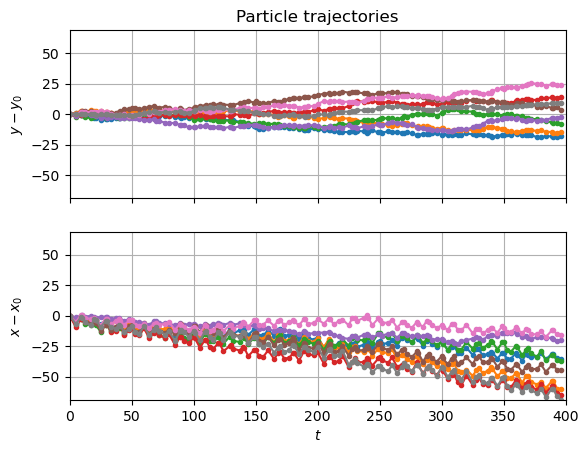

In [6]:
# Plot trajectories

assert _SIMULATOR_OK

# relative displacement vector
r = trajectories - trajectories[0]

fig, axs = plt.subplots(2,1)

NT = 8
TMAX = 400

t = np.arange(len(tmask_full))[tmask_full]

tmask = t < TMAX

XMAX = max(r[tmask,0:NT].max(),np.abs(r[tmask,0:NT].min()))
XMIN = -XMAX

for i in range(NT):
    axs[0].plot(t[tmask],r[tmask,i,0], f"C{i}", label = i)
    axs[0].plot(t[tmask],r[tmask,i,0], f".C{i}", label = i)

for i in range(NT):
    axs[1].plot(t[tmask],r[tmask,i,1], f"C{i}", label = i)
    axs[1].plot(t[tmask],r[tmask,i,1], f".C{i}", label = i)

for i in range(2):
    axs[i].set_ylim(-XMAX,XMAX)
    axs[i].grid()
    axs[i].set_xlim(0, TMAX)
axs[0].set_ylabel("$y - y_0$")
axs[1].set_ylabel("$x - x_0$")
axs[1].set_xlabel("$t$")
axs[0].set_xticklabels([])

axs[0].set_title("Particle trajectories")
print()

if SAVE_FIGS:
    plt.savefig("trajectories.png")

##  Microscope video simulator


In [7]:
# Define video acquisition

class ImageArray(np.ndarray):
    def __new__(cls, input_array, is_valid=None):        
        obj = np.asarray(input_array).view(cls)
        obj.is_valid = is_valid
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return
        self.is_valid= getattr(obj, 'is_valid', None)


def iterate_images(xs, luts, window = None, apply_adc = True, tmask = None):
    #shape = RFFT2_MASK.shape
    # zero (empty image) data 
    zero = zeros(SENSOR_SHAPE)
    # set valid flag to False to notify that this is an empty image.
    zero = ImageArray(zero, is_valid = False)
    
    tmask = np.ones(len(xs), dtype = "bool") if tmask is None else np.asarray(tmask, dtype = "bool")
    j = 0
    for i in tmask:
        if i == True:
            im = draw_particles_2d(xs[j],luts)
            if apply_adc:
                im = sensor_image(im)
            if window is not None:
                im *= window
            #return valid non-empty image
            yield ImageArray(im, is_valid = True)
            j+=1
        else:
            #return empty (invalid imaga)
            yield zero

def iterate_data(images, kmask = None):
    zero = zeros(SENSOR_SHAPE)
    f = rfft2(zero)[kmask]
    f0 = ImageArray(f, is_valid = False)
    for im in images:
        if im.is_valid == True:
            f = rfft2(im)[kmask]
            f = ImageArray(f, is_valid = True)
            yield f
        else:
            yield f0

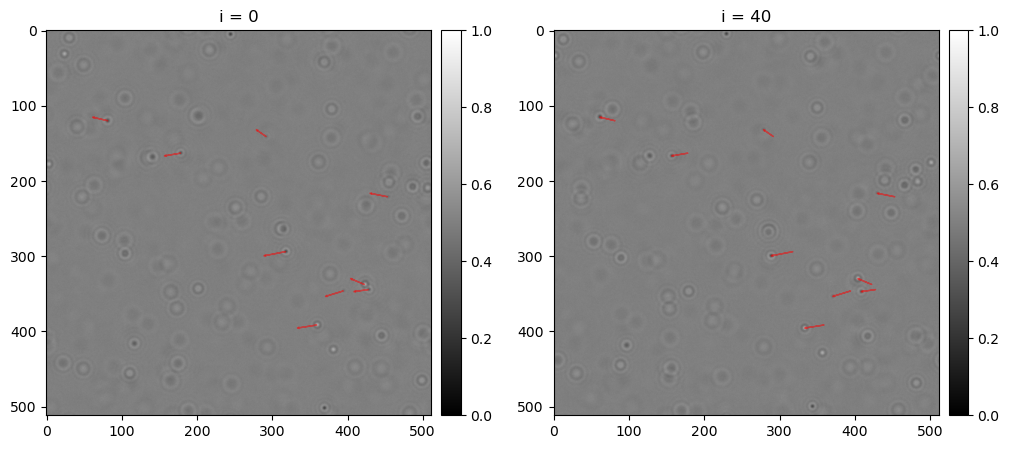

In [8]:
# Simulation example 
assert_simulator_ok()

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(fig,im,ax, pad = 0.1, pack_start = False):
    # add color bar below chart
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size = '5%', pad = pad ,pack_start = pack_start)
    fig.add_axes(cax)
    
    fig.colorbar(im, cax = cax, orientation = 'vertical')

vmin = 0.4
vmax = 0.6

#fig,axs = plt.subplots(1,2, figsize = (12,5))
#im = axs[0].imshow(im_true, vmin = vmin, vmax = vmax, cmap = "gray")
#add_colorbar(fig,im,axs[0])
#axs[0].set_title(f"Ideal lens (NA = {REFIND}) field intensity")
#im = axs[1].imshow(im_lens, vmin = vmin, vmax = vmax, cmap = "gray")
#add_colorbar(fig,im,axs[1])
#axs[1].set_title(f"True lens (NA = {NA}) sensor image")


zmask = np.logical_and(particle_zs > NUM_LAYERS//2 - 5, particle_zs < NUM_LAYERS//2 + 5)

#zmask = np.logical_and(particle_zs > 0, particle_zs < 10)


slice_luts = fft_luts[particle_zs[zmask]]

Ii = 0
If = 40

r0 = trajectories[Ii]
r1 = trajectories[If]


#plt.figure()

dx = (r1 - r0)[...,1]

#plt.plot(particle_zs, dx, ".")

images = [im for im in iterate_images([r0,r1],luts)]

fig,axs = plt.subplots(1,2, figsize = (12,5))

im = axs[0].imshow(images[0], cmap = "gray", vmin = 0, vmax = 1)
add_colorbar(fig,im,axs[0])
im = axs[1].imshow(images[1], cmap = "gray", vmin = 0, vmax = 1)
add_colorbar(fig,im,axs[1])

axs[0].set_title(f"i = {Ii}")
axs[1].set_title(f"i = {If}")

MARGIN = 32

r0 = r0[zmask]
r1 = r1[zmask]

m0 = np.logical_and(r0[...,0] > MARGIN , r0[...,1] > MARGIN)
m1 = np.logical_and(r1[...,0] > MARGIN , r1[...,1] > MARGIN)
m2 = np.logical_and(r1[...,0] < HEIGHT-MARGIN, r1[...,1] < WIDTH-MARGIN)
m = np.logical_and(m0,m1)
m = np.logical_and(m,m2)

count = 0

for x0,x1 in zip(r0[m][::1],r1[m][::1]):
    count += 1
    dx = x1-x0
    axs[0].arrow(x0[1], x0[0],dx[1],dx[0], lw = 1, alpha = 0.5, color = "r",head_width = 2,length_includes_head = True)

    axs[1].arrow(x0[1], x0[0],dx[1],dx[0], lw = 1, alpha = 0.5, color = "r",head_width = 2,length_includes_head = True)

if SAVE_FIGS:
    plt.savefig("particle_video.png")

### Video example

Here we perform a test video acquisition to demonstrate how to use the 'iterate_images' function. If we use random sampling scheme, as defined by 

```python
>>> USE_RANDOM_SAMPLING = True
```
then the frames are non-zero only at times defined by 'tmask_full'. For regular sampling scheme, then all frames are valid.

In [9]:
TEST_COUNT = 128

print("Generating video example")

images = iterate_images(trajectories,luts, tmask = tmask_full)

test_images = []

for i,image in enumerate(images):
    if i == TEST_COUNT:
        break
    if i%(TEST_COUNT//32) == 0:
        print_progress(i,TEST_COUNT)
    test_images.append(image)
print_progress(TEST_COUNT,TEST_COUNT)

from ipywidgets import interact

def show_video(i):
    plt.imshow(test_images[i],cmap = "gray", vmin = 0, vmax = 1)

ivideo_plot = interact(show_video, i = (0,TEST_COUNT-1,1))

Generating video example
|==================================================| 100.0 % Done in  8.3 s


interactive(children=(IntSlider(value=63, description='i', max=127), Output()), _dom_classes=('widget-interact…